# Comparison of SB3 Soft Actor-Critic CTCE trained agents with different reward functions
### Trained for 3.960.000 steps (720 (episode) x 5500)

In [1]:
import numpy as np 
import pandas as pd

import math
import sys
import os
import time

import gym
gym.__version__

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from citylearn.reward_function import RewardFunction
from citylearn.agents.base import Agent

from stable_baselines3 import SAC

import seaborn as sns
import matplotlib.pyplot as plt

import tensorboard as tb
from tbparse import SummaryReader

In [2]:
sys.path.append("../")
!source venv/bin/activate

### Initialize environment

In [3]:
schema_path = os.path.join("./data/", "schema_edited.json")

# create environment
env = CityLearnEnv(schema=schema_path, reward_function = RewardFunction, central_agent=True)

# wrap environment for use in stablebaselines3
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)

### Load models

In [4]:
# Given reward functions
model_energy_reward = SAC.load("habrok_training_results/simple_policy/training_energy_reward3/models/energy_reward_SAC.zip")
model_energy_reward.set_env(env)

model_comfort_reward = SAC.load("habrok_training_results/simple_policy/training_comfort_reward3/models/comfort_reward_SAC.zip")
model_comfort_reward.set_env(env)

model_solar_reward = SAC.load("habrok_training_results/simple_policy/training_solar_reward3/models/solar_reward_SAC.zip")
model_solar_reward.set_env(env)

model_solarcomfort_reward = SAC.load("habrok_training_results/simple_policy/training_solarcomfort_reward3/models/solarcomfort_reward_SAC.zip")
model_solarcomfort_reward.set_env(env)

# Custom reward function
model_custom_reward = SAC.load("habrok_training_results/simple_policy/training_custom_reward3/models/custom_reward_SAC.zip")
model_custom_reward.set_env(env)

model_relax_custom_reward = SAC.load("habrok_training_results/simple_policy/training_relax_custom_reward3/models/custom_reward_SAC.zip")
model_relax_custom_reward.set_env(env)

/home/hkolstee/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/hkolstee/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


### Evaluate

In [5]:
def update_power_outage_random_seed(env: CityLearnEnv, random_seed: int) -> CityLearnEnv:
    """Update random seed used in generating power outage signals.
    
    Used to optionally update random seed for stochastic power outage model in all buildings.
    Random seeds should be updated before calling :py:meth:`citylearn.citylearn.CityLearnEnv.reset`.
    """
    for b in env.buildings:
        b.stochastic_power_outage_model.random_seed = random_seed

    return env

In [6]:
def evaluate(agent, env, name, nr_episodes):
    observations = env.reset()

    for episode in range(nr_episodes):
        while not env.done:
            actions, _ = agent.predict(observations, deterministic=True)
            observations, _, _, _ = env.step(actions)
        if episode == 0:
            kpis = env.evaluate()
        else:
            kpis["value"] += env.evaluate()["value"]
        
        # update power outage seed
        # env = update_power_outage_random_seed(env, 90000)
    
    # average
    kpis["value"] /= nr_episodes

    kpis.insert(0, "Reward function", name)
    # kpis = kpis.pivot(index=['cost_function', 'Reward function'], columns='name', values='value')    
    kpis = kpis.dropna(how='all')

    return kpis

In [7]:
kpis_energy = evaluate(model_energy_reward, env, "Energy reward", 4)
kpis_comfort = evaluate(model_comfort_reward, env, "Comfort reward", 4)
kpis_solar = evaluate(model_solar_reward, env, "Solar reward", 4)
kpis_solarcomfort = evaluate(model_solarcomfort_reward, env, "Comfort+solar reward", 4)
kpis_custom = evaluate(model_custom_reward, env, "Custom reward", 4)
kpis_relax_custom = evaluate(model_relax_custom_reward, env, "Custom reward relaxed", 4)

In [8]:
kpis = pd.DataFrame()

kpis = kpis.append(kpis_energy)
kpis = kpis.append(kpis_comfort)
kpis = kpis.append(kpis_solar)
kpis = kpis.append(kpis_solarcomfort)
kpis = kpis.append(kpis_custom)
kpis = kpis.append(kpis_relax_custom)

desc_list = []
for function in kpis["cost_function"]:
    if (function == "annual_normalized_unserved_energy_total"):
        desc_list.append("Annual proportion of unmet demand due to supply shortage e.g. power outage (normalized).")
    elif (function == "annual_peak_average"):
        desc_list.append("Annual peak electricity consumption (normalized).")
    elif (function == "carbon_emissions_total"):
        desc_list.append("Total carbon emissions due to electricity drawn from the grid (normalized).")
    elif (function == "cost_total"):
        desc_list.append("Total electricity monetary cost (normalized).")
    elif (function == "daily_one_minus_load_factor_average"):
        desc_list.append("Daily difference ratio of rolling mean demand to rolling peak demand over a specified period (normalized).")
    elif (function == "daily_peak_average"):
        desc_list.append("Daily average peak electricity consumption (normalized).")
    elif (function == "discomfort_delta_average"):
        desc_list.append("Mean temperature delta from the temperature setpoint.")
    elif (function == "discomfort_delta_maximum"):
        desc_list.append("Maximum temperature delta from the temperature setpoint.")  
    elif (function == "discomfort_delta_minimum"):
        desc_list.append("Minimum temperature delta from the temperature setpoint.")  
    elif (function == "discomfort_proportion"):
        desc_list.append("Proportion of occupied timesteps where the temperature falls outside of the comfort band from the temperature setpoint.")
    elif (function == "discomfort_too_cold_proportion"):
        desc_list.append("Proportion of occupied timesteps where the temperature falls below the comfort band from the temperature setpoint.")  
    elif (function == "discomfort_too_hot_proportion"):
        desc_list.append("Proportion of occupied timesteps where the temperature falls above the comfort band from the temperature setpoint.")  
    elif (function == "electricity_consumption_total"):
        desc_list.append("Total electricity that is consumed from the grid. (normalized).")  
    elif (function == "monthly_one_minus_load_factor_average"):
        desc_list.append("Monthly difference between 1 and the load factor i.e., ratio of rolling mean demand to rolling peak demand over a specified period (normalized).")  
    elif (function == "one_minus_thermal_resilience_proportion"):
        desc_list.append("Percentage of discomfort time steps during power outage.")  
    elif (function == "power_outage_normalized_unserved_energy_total"):
        desc_list.append("Proportion of unmet demand while in a power outage.")  
    elif (function == "ramping_average"):
        desc_list.append("Rolling sum of absolute difference in net electric consumption between consecutive time steps (normalized).")
    elif (function == "zero_net_energy"):
        desc_list.append("The net sum of electricty that is consumed from the grid and self-generated from renenewable sources (normalized).")  
        
# print(desc_list)

kpis.insert(2, "description", desc_list, True)
display(kpis.head(5))

,Reward function,cost_function,description,value,name,level
0,Energy reward,annual_normalized_unserved_energy_total,Annual proportion of unmet demand due to suppl...,0.073886,District,district
1,Energy reward,annual_peak_average,Annual peak electricity consumption (normalized).,0.662279,District,district
2,Energy reward,carbon_emissions_total,Total carbon emissions due to electricity draw...,0.413884,District,district
3,Energy reward,cost_total,Total electricity monetary cost (normalized).,0.393530,District,district
4,Energy reward,daily_one_minus_load_factor_average,Daily difference ratio of rolling mean demand ...,1.205246,District,district


In [9]:
pd.set_option('display.max_rows', 1000)
kpis = kpis.pivot(index=["cost_function", "description", "Reward function"], columns="name", values="value")
kpis = kpis.sort_values(["cost_function", "Reward function"])

display(kpis.head(5))

name                                                                                                              Building_1  \
cost_function                           description                                        Reward function                     
annual_normalized_unserved_energy_total Annual proportion of unmet demand due to supply... Comfort reward           0.031561   
                                                                                           Comfort+solar reward     0.032479   
                                                                                           Custom reward            0.033531   
                                                                                           Custom reward relaxed    0.047471   
                                                                                           Energy reward            0.082078   

name                                                                                                              Building_2  \
cost_function                           description                                        Reward function                     
annual_normalized_unserved_energy_total Annual proportion of unmet demand due to supply... Comfort reward           0.015283   
                                                                                           Comfort+solar reward     0.033413   
                                                                                           Custom reward            0.026479   
                                                                                           Custom reward relaxed    0.024261   
                                                                                           Energy reward            0.092174   

name                                                                                                              Building_3  \
cost_function                           description                                        Reward function                     
annual_normalized_unserved_energy_total Annual proportion of unmet demand due to supply... Comfort reward           0.030010   
                                                                                           Comfort+solar reward     0.029090   
                                                                                           Custom reward            0.030843   
                                                                                           Custom reward relaxed    0.048739   
                                                                                           Energy reward            0.047404   

name                                                                                                              District  
cost_function                           description                                        Reward function                  
annual_normalized_unserved_energy_total Annual proportion of unmet demand due to supply... Comfort reward         0.025618  
                                                                                           Comfort+solar reward   0.031661  
                                                                                           Custom reward          0.030284  
                                                                                           Custom reward relaxed  0.040157  
                                                                                           Energy reward          0.073886

In [10]:
display(kpis.loc[("ramping_average")])

name                                                                      Building_1  \
description                                        Reward function                     
Rolling sum of absolute difference in net elect... Comfort reward                NaN   
                                                   Comfort+solar reward          NaN   
                                                   Custom reward                 NaN   
                                                   Custom reward relaxed         NaN   
                                                   Energy reward                 NaN   
                                                   Solar reward                  NaN   

name                                                                      Building_2  \
description                                        Reward function                     
Rolling sum of absolute difference in net elect... Comfort reward                NaN   
                                                   Comfort+solar reward          NaN   
                                                   Custom reward                 NaN   
                                                   Custom reward relaxed         NaN   
                                                   Energy reward                 NaN   
                                                   Solar reward                  NaN   

name                                                                      Building_3  \
description                                        Reward function                     
Rolling sum of absolute difference in net elect... Comfort reward                NaN   
                                                   Comfort+solar reward          NaN   
                                                   Custom reward                 NaN   
                                                   Custom reward relaxed         NaN   
                                                   Energy reward                 NaN   
                                                   Solar reward                  NaN   

name                                                                      District  
description                                        Reward function                  
Rolling sum of absolute difference in net elect... Comfort reward         1.854205  
                                                   Comfort+solar reward   0.929273  
                                                   Custom reward          0.337397  
                                                   Custom reward relaxed  1.642668  
                                                   Energy reward          0.636595  
                                                   Solar reward           0.767537

In [11]:
# apparantly termal is switched when loading a model in pytorch, therefore we need to switch back to original terminal
# import matplotlib
# matplotlib.use('TkAgg')

In [12]:
%matplotlib inline

### Training plots in relation to the Key Performance Indicators (KPIs)

In [13]:
# read tensorboard training data
log_dir = "habrok_training_results/simple_policy/"
reader = SummaryReader(log_dir, extra_columns = {'dir_name'})

In [14]:
display(reader.scalars.head(5))

,step,tag,value,dir_name
0,719,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
1,1438,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
2,2157,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
3,2876,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
4,3595,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3


In [15]:
# comfort
comfort_data = reader.scalars[reader.scalars["dir_name"].str.contains("training_comfort_")]
# solar
solar_data = reader.scalars[reader.scalars["dir_name"].str.contains("training_solar_")]
# solar+comfort
solarcomfort_data = reader.scalars[reader.scalars["dir_name"].str.contains("training_solarcomfort_")]
# energy
energy_data = reader.scalars[reader.scalars["dir_name"].str.contains("training_energy_")]
# custom
custom_data = reader.scalars[reader.scalars["dir_name"].str.contains("training_custom_")]
# custom relaxed
custom_r_data = reader.scalars[reader.scalars["dir_name"].str.contains("training_relax_custom_")]

In [16]:
display(comfort_data.head(40))

,step,tag,value,dir_name
0,719,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
1,1438,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
2,2157,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
3,2876,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
4,3595,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
5,4314,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
6,5033,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
7,5752,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
8,6471,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3
9,7190,rollout/ep_len_mean,719.0,training_comfort_reward1/tensorboard_logs/SAC_3


In [49]:
for kpi in comfort_data.groupby("tag"):
    sns.lineplot(data = comfort_data, x = "step", y = "value", hue = "dir_name")

### Barplots of Key Performance Indicators (KPIs)

In [32]:
def plotKpi(cost_func, values):
    plt.figure()
    
    sns.set_palette(sns.color_palette("hls", 20))
    barplot = sns.catplot(data = values, y = "District", kind = "bar", hue = "Reward function", palette=["C10", "C11", "C0", "C1", "C12", "C13"])
    # barplot = sns.catplot(data = values, y = "District", kind = "bar", hue = "Reward function", palette=["C10", "C11", "C0", "C12", "C13"])
    plt.title(values.index.get_level_values("description")[0], wrap = True)
    barplot.set_axis_labels("", "value")
    plt.suptitle("KPI: " + cost_func, weight = "bold", x = 0.43, y = 1.15)
    
    plt.show()
    
    # close figures explicitly
    plt.close()

<Figure size 640x480 with 0 Axes>

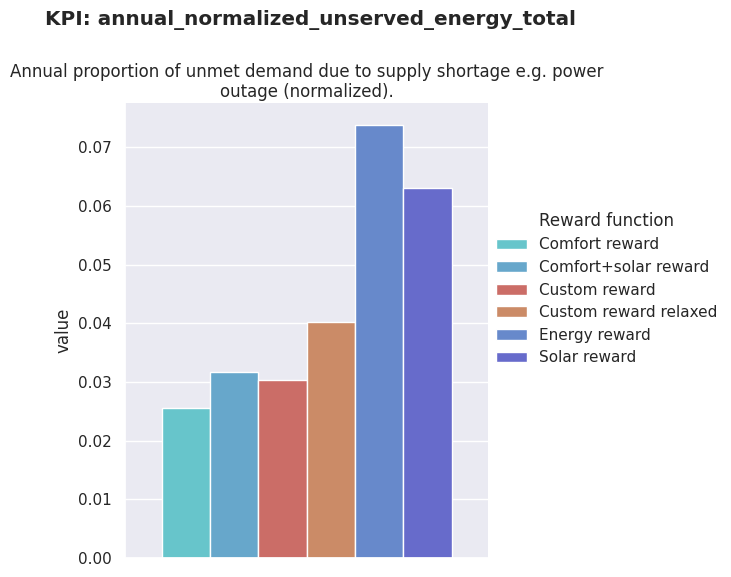

<Figure size 640x480 with 0 Axes>

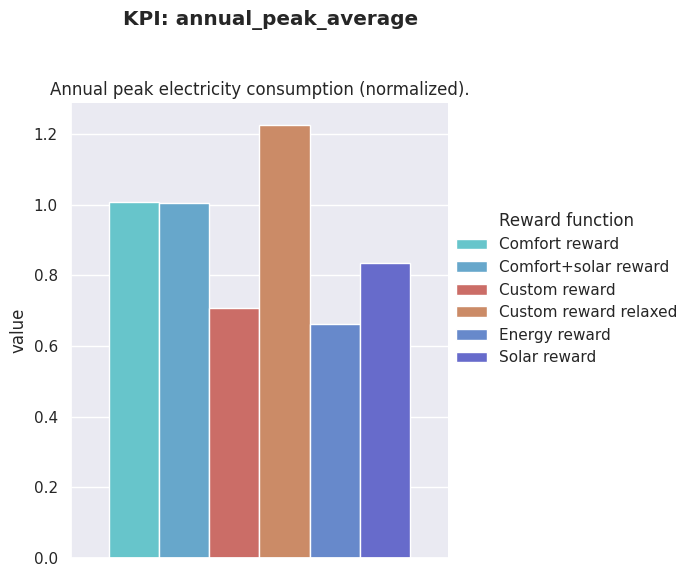

<Figure size 640x480 with 0 Axes>

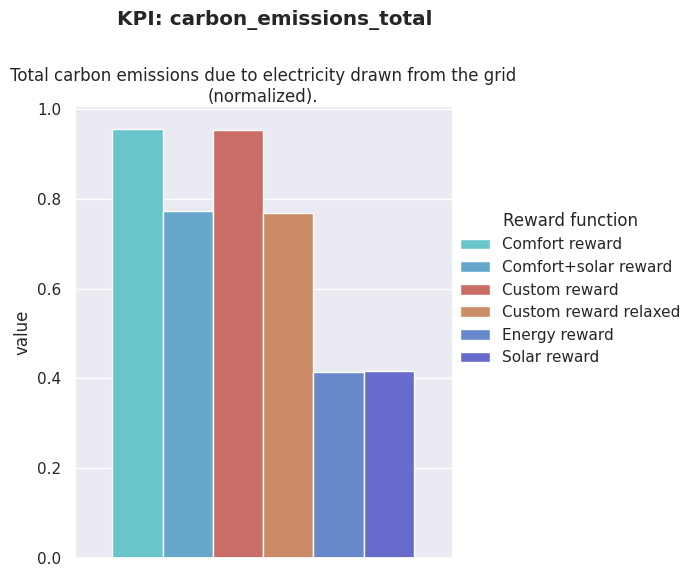

<Figure size 640x480 with 0 Axes>

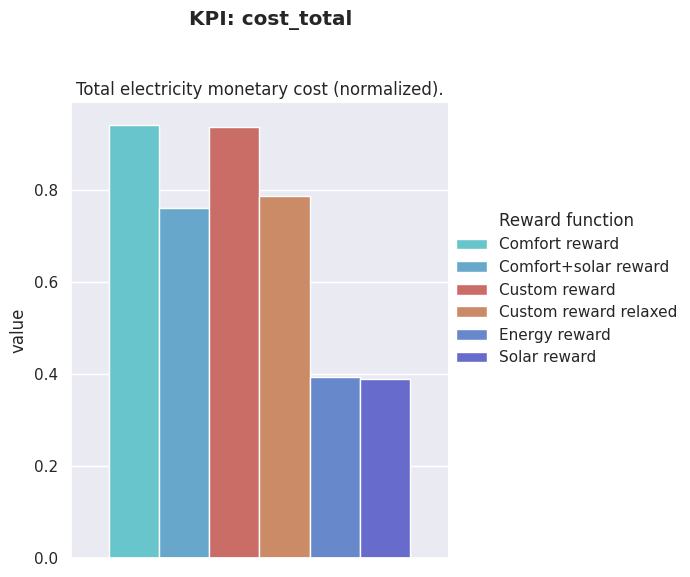

<Figure size 640x480 with 0 Axes>

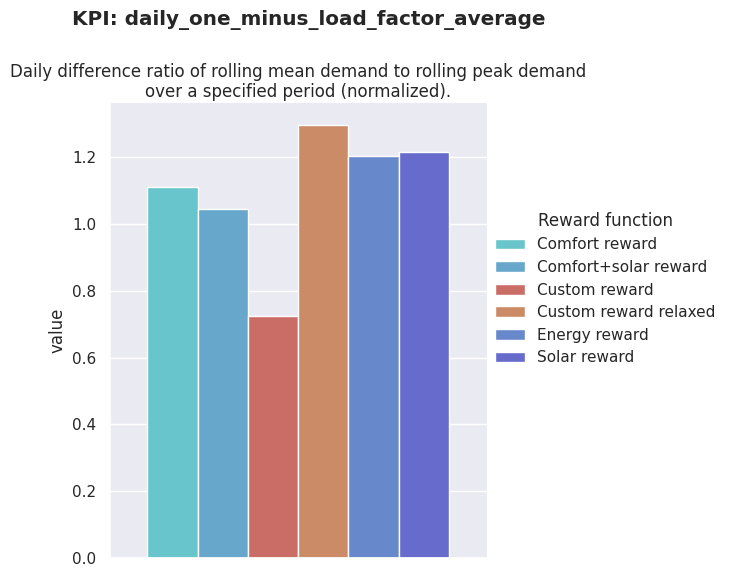

<Figure size 640x480 with 0 Axes>

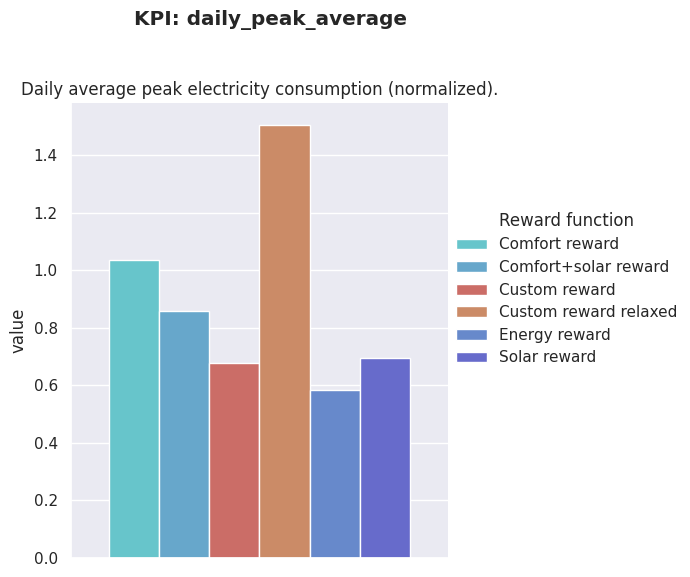

<Figure size 640x480 with 0 Axes>

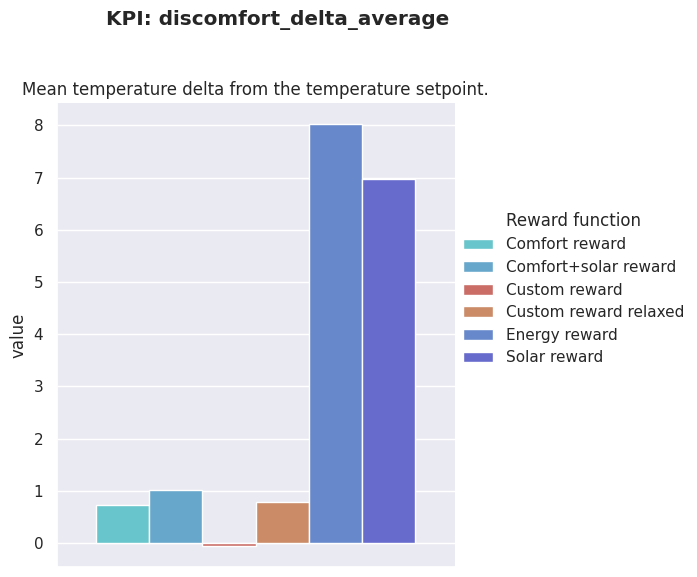

<Figure size 640x480 with 0 Axes>

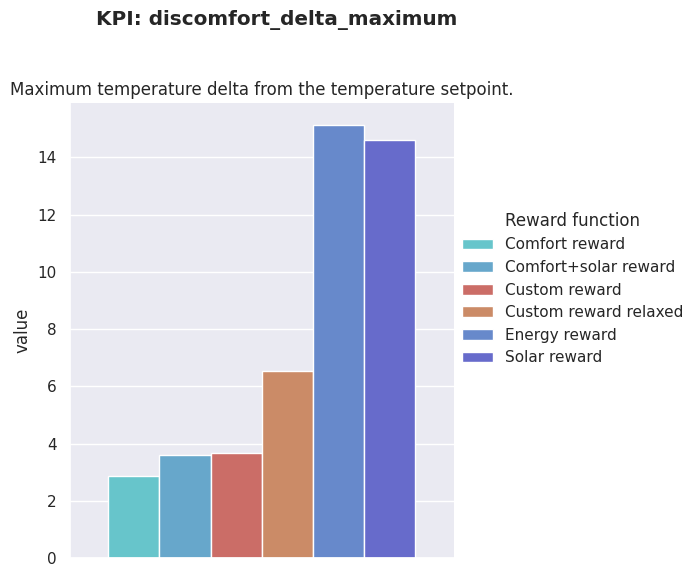

<Figure size 640x480 with 0 Axes>

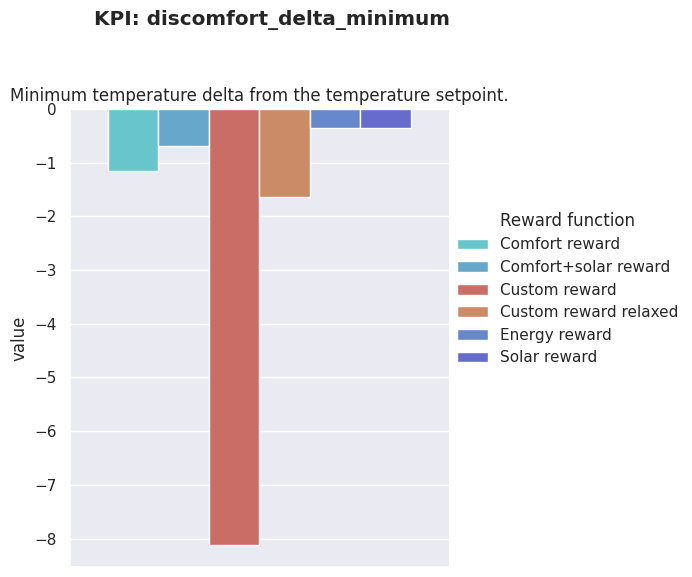

<Figure size 640x480 with 0 Axes>

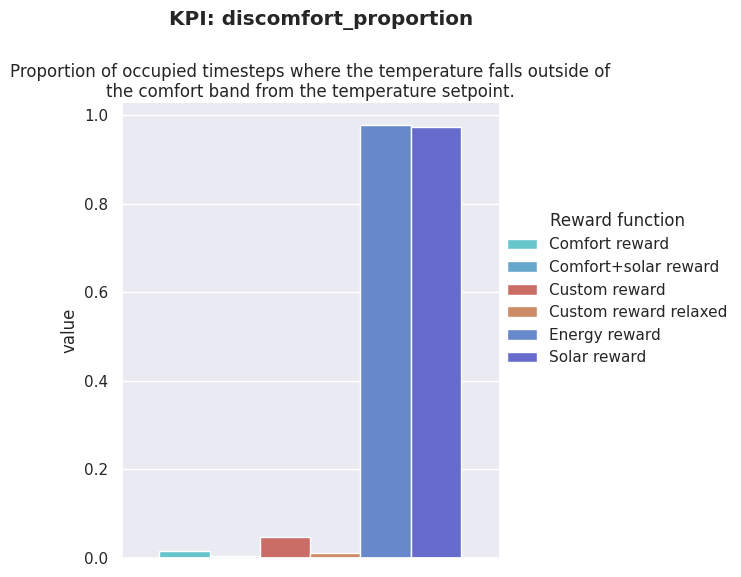

<Figure size 640x480 with 0 Axes>

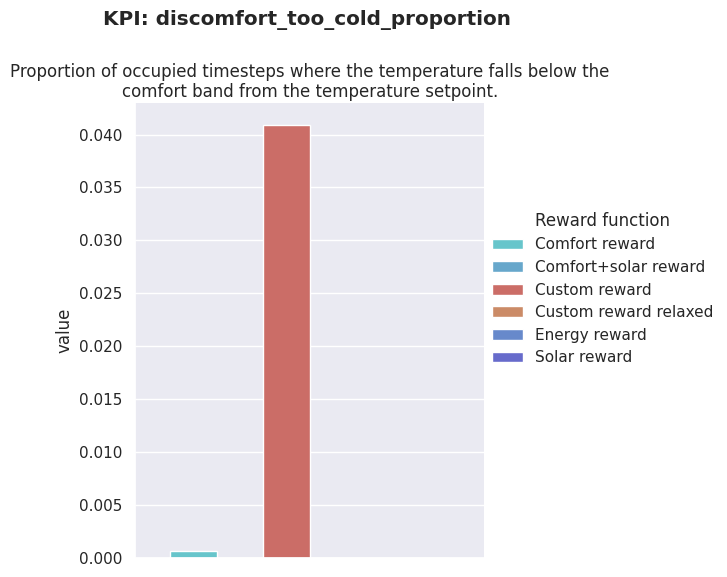

<Figure size 640x480 with 0 Axes>

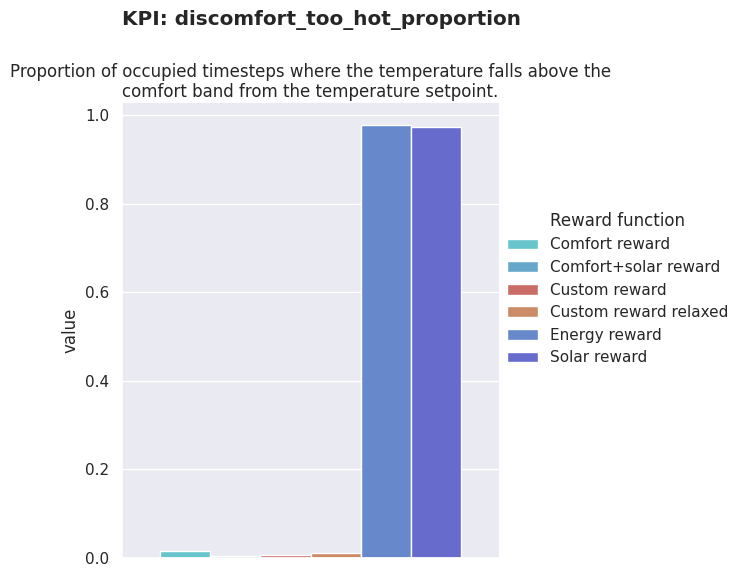

<Figure size 640x480 with 0 Axes>

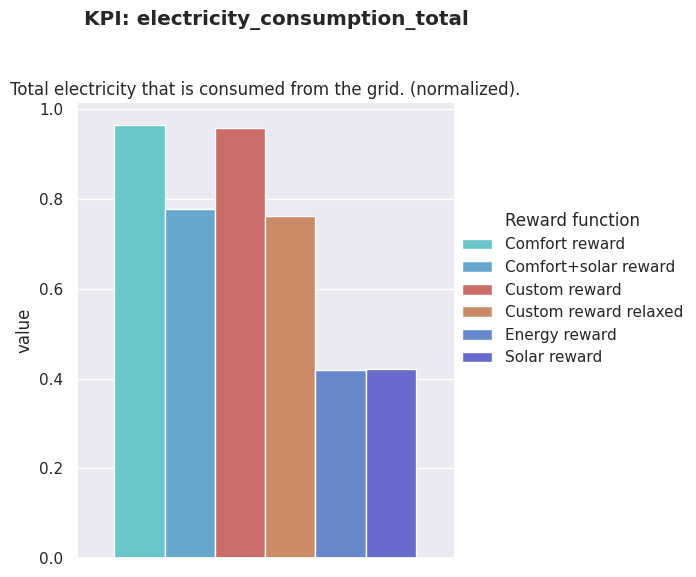

<Figure size 640x480 with 0 Axes>

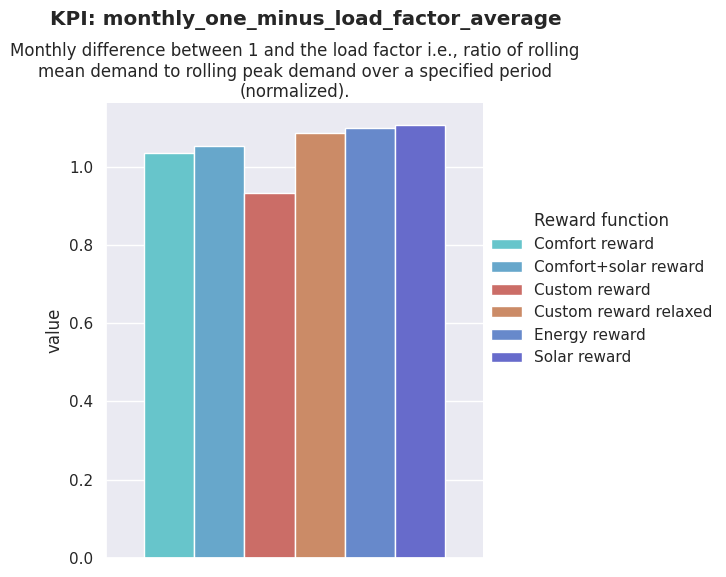

<Figure size 640x480 with 0 Axes>

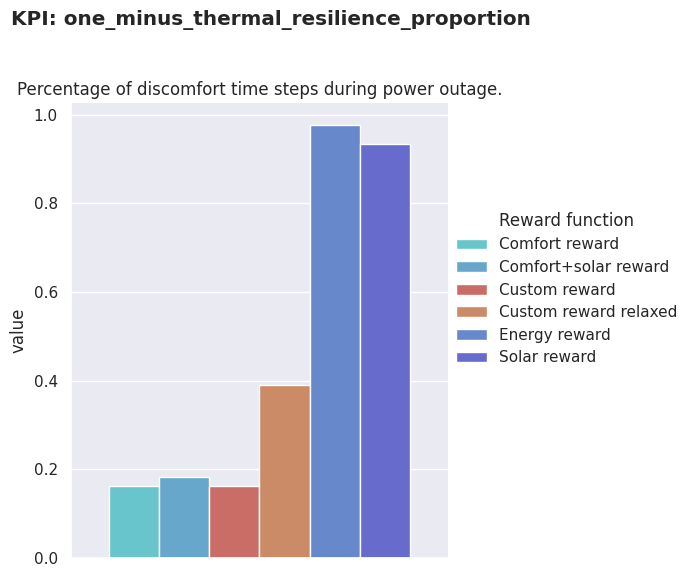

<Figure size 640x480 with 0 Axes>

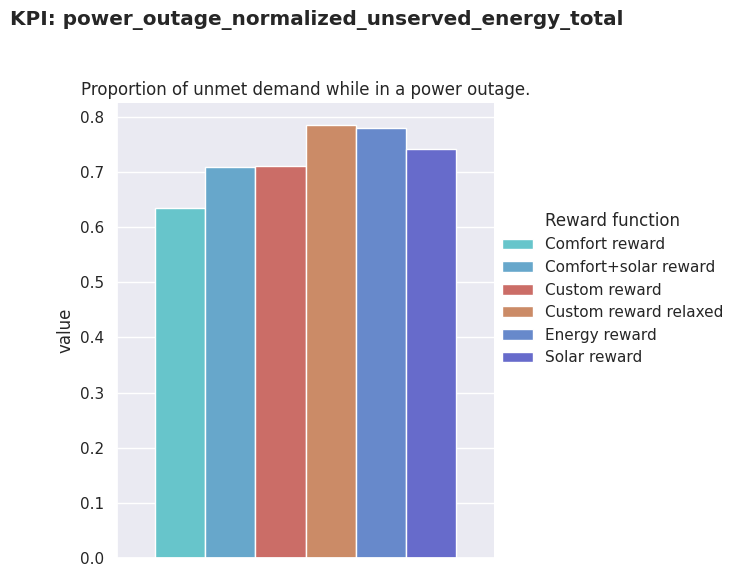

<Figure size 640x480 with 0 Axes>

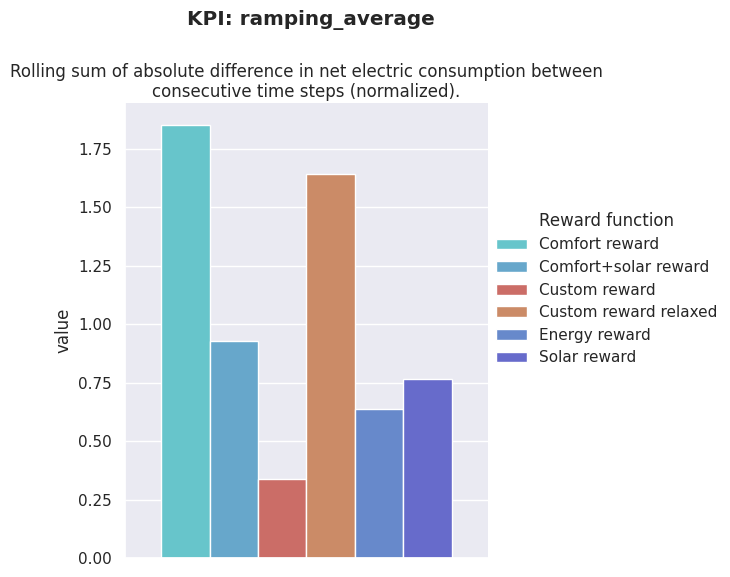

<Figure size 640x480 with 0 Axes>

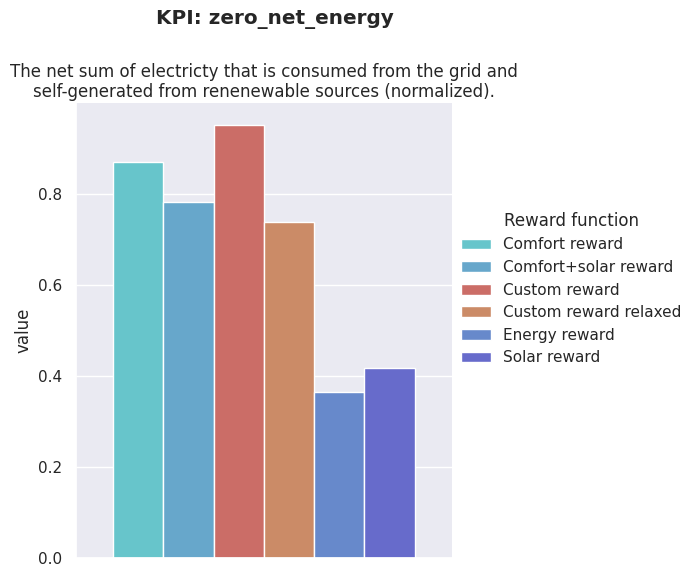

In [33]:
sns.set_theme()
# sns.set_palette(sns.color_palette("pastel"))
# sns.set_palette(sns.color_palette("hls", 20))

for cost_func, values in kpis.groupby(level = 0):
    plotKpi(cost_func, values)

### Final score calculation

In [20]:
def calculateFinalScore(kpis: pd.DataFrame):
    # get reward function names
    reward_funcs = kpis.index.unique("Reward function")
    # display(kpis.index.unique("cost_function"))
    
    # create new score dataframe
    final_scores = pd.DataFrame(columns = ["cost_function", "description", "Reward function",  "value"])
    
    # get key performace indicator values per reward func 
    for f in reward_funcs:
        # get values for current reward func
        kpis_f = kpis.xs(f, level = "Reward function")
        # display(kpis_f)
        
        # KPIS:
        # carbon emissions
        g = kpis_f.loc["carbon_emissions_total", "District"][0]
        # unmet hours
        u = kpis_f.loc["discomfort_proportion", "District"][0]
        # ramping
        r = kpis_f.loc["ramping_average", "District"][0]
        # 1 - load factor
        l = kpis_f.loc["daily_one_minus_load_factor_average", "District"][0]
        # daily peak
        d = kpis_f.loc["daily_peak_average", "District"][0]
        # all-time peak
        a = kpis_f.loc["annual_peak_average", "District"][0]
        # 1 - thermal resilience
        m = kpis_f.loc["one_minus_thermal_resilience_proportion", "District"][0]
        # normalized unserved energy
        s = kpis_f.loc["power_outage_normalized_unserved_energy_total", "District"][0]    
        
        # SCORE COMPONENTS (weights from citylearn challenge 2023):
        comfort = 0.3 * u
        emissions = 0.1 * g
        grid = 0.3 * (r + l + d + a) / 4
        resilience = 0.3 * (m + s) / 2
        
        # FINAL SCORE:
        score = comfort + emissions + grid + resilience
        
        # add score (and components) to kpi dataframe
        final_scores = final_scores.append(pd.DataFrame({"cost_function": ["Comfort"], 
                                                         "description": ["The comfort score component calculated using the citylearn 2023 challenge formula. Optimal is zero."],
                                                         "Reward function": [f],
                                                         "value": [comfort],
                                                         "name": "District"}))
        final_scores = final_scores.append(pd.DataFrame({"cost_function": ["Emissions"], 
                                                         "description": ["The emissions score component calculated using the citylearn 2023 challenge formula. Optimal is zero."],
                                                         "Reward function": [f],
                                                         "value": [emissions],
                                                         "name": "District"}))
        final_scores = final_scores.append(pd.DataFrame({"cost_function": ["Grid"], 
                                                         "description": ["The grid score component calculated using the citylearn 2023 challenge formula. Optimal is zero."],
                                                         "Reward function": [f],
                                                         "value": [grid],
                                                         "name": "District"}))
        final_scores = final_scores.append(pd.DataFrame({"cost_function": ["Resilience"], 
                                                         "description": ["The resilience score component calculated using the citylearn 2023 challenge formula. Optimal is zero."],
                                                         "Reward function": [f],
                                                         "value": [resilience],
                                                         "name": "District"}))
        final_scores = final_scores.append(pd.DataFrame({"cost_function": ["Final"], 
                                                         "description": ["The final performance score calculated using the citylearn 2023 challenge formula. Optimal is zero."],
                                                         "Reward function": [f],
                                                         "value": [score],
                                                         "name": "District"}))
                    
        
    final_scores = final_scores.pivot(index=["cost_function", "description", "Reward function"], columns="name", values="value")
    final_scores = final_scores.sort_values(["cost_function", "Reward function"])
    
    return final_scores        

In [21]:
scores = calculateFinalScore(kpis)
display(scores)

name                                                                                    District
cost_function description                                        Reward function                
Comfort       The comfort score component calculated using th... Comfort reward         0.004737
                                                                 Comfort+solar reward   0.001427
                                                                 Custom reward          0.014381
                                                                 Custom reward relaxed  0.003140
                                                                 Energy reward          0.293635
                                                                 Solar reward           0.292092
Emissions     The emissions score component calculated using ... Comfort reward         0.095604
                                                                 Comfort+solar reward   0.077317
                                                                 Custom reward          0.095360
                                                                 Custom reward relaxed  0.076924
                                                                 Energy reward          0.041388
                                                                 Solar reward           0.041668
Final         The final performance score calculated using th... Comfort reward         0.595293
                                                                 Comfort+solar reward   0.500316
                                                                 Custom reward          0.424183
                                                                 Custom reward relaxed  0.681885
                                                                 Energy reward          0.830165
                                                                 Solar reward           0.848503
Grid          The grid score component calculated using the c... Comfort reward         0.375536
                                                                 Comfort+solar reward   0.287860
                                                                 Custom reward          0.183656
                                                                 Custom reward relaxed  0.425421
                                                                 Energy reward          0.231642
                                                                 Solar reward           0.263640
Resilience    The resilience score component calculated using... Comfort reward         0.119416
                                                                 Comfort+solar reward   0.133711
                                                                 Custom reward          0.130786
                                                                 Custom reward relaxed  0.176400
                                                                 Energy reward          0.263499
                                                                 Solar reward           0.251104

### Final score plot

In [46]:
def plotKpiStacked(scores):
    nr_components = len(scores.index.unique("cost_function"))
    nr_reward_func = len(scores.index.unique("Reward function"))
    
    # colors
    sns.set_theme(rc = {"axes.spines.bottom": True})
    # sns.set_palette(sns.color_palette("pastel"))
    colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    while len(colors) < 2 * nr_components:
        colors += colors
    colors = colors[:nr_components]

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(nr_reward_func)

    # plot bars
    cell_text = []
    for idx, (component, dataframe) in enumerate(scores.groupby(level = 0)):
        # barplot
        sns.barplot(data = dataframe, x = "Reward function", y = "District", width = 0.6, bottom = y_offset, color = colors[idx % 8])

        # bar stacking offset
        y_offset += dataframe.values[:,[-1]].flatten()
        # for table
        cell_text.append(["{:.3f}".format(x) for x in dataframe.values[:,[-1]].flatten()])


    # Reverse colors and text labels such that top value is top in table
    colors = colors[::-1]
    cell_text.reverse()

    # Add a table at the bottom of the axes
    table = plt.table(cellText = cell_text,
                      rowLabels = scores.index.unique("cost_function").values[::-1],
                    #   rowColours = colors[0 : len(scores.index.unique("cost_function").values)]
                      rowColours = colors,
                      colLabels = [string.replace(" reward", "").replace("Custom relaxed", "C. relaxed").replace("Comfort+solar", "Comf+Sol") for string in scores.index.unique("Reward function").values],
                      loc='bottom')
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Adjust layout to make room for the table:
    plt.ylabel("Value")
    # plt.yticks(values * value_increment, ['%d' % val for val in values])
    plt.xlabel("")
    plt.xticks([])
    plt.subplots_adjust(left=0.1, bottom= -0.1)
    plt.title("The components of the final score", weight = "bold")

    plt.show()

    plt.close()

<Figure size 640x480 with 0 Axes>

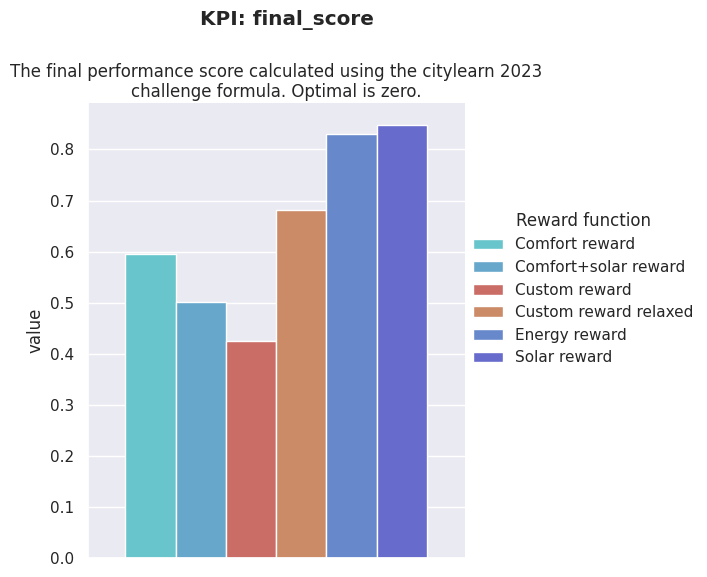

['C0', 'C1', 'C2', 'C3']
['C3', 'C2', 'C1', 'C0']


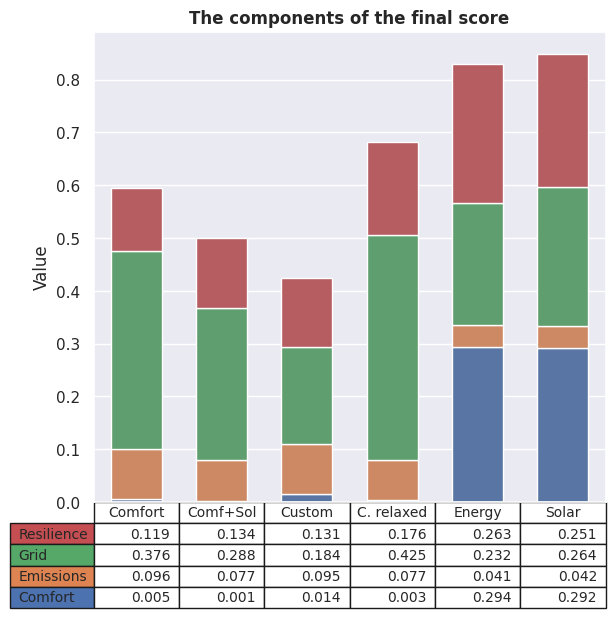

name                                                                      District
description                                        Reward function                
The final performance score calculated using th... Comfort reward         0.595293
                                                   Comfort+solar reward   0.500316
                                                   Custom reward          0.424183
                                                   Custom reward relaxed  0.681885
                                                   Energy reward          0.830165
                                                   Solar reward           0.848503

In [47]:
plotKpi("final_score", scores.loc[("Final")])
scores.drop('Final', level=0, axis=0, inplace=True) 
plotKpiStacked(scores)
scores = calculateFinalScore(kpis)
display(scores.loc["Final"])

['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
['C7', 'C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']


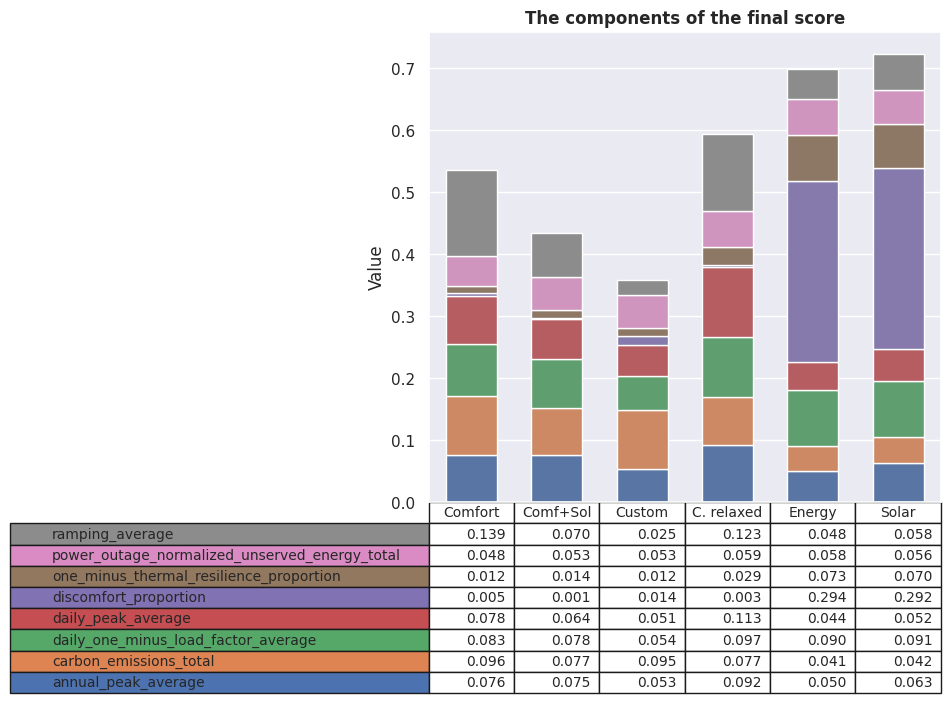

In [48]:
score_kpis = kpis.copy()

# drop score irrelevant kpis
score_kpis.drop("zero_net_energy", level=0, axis=0, inplace=True) 
score_kpis.drop("monthly_one_minus_load_factor_average", level=0, axis=0, inplace=True) 
score_kpis.drop("electricity_consumption_total", level=0, axis=0, inplace=True) 
score_kpis.drop("discomfort_too_hot_proportion", level=0, axis=0, inplace=True) 
score_kpis.drop("discomfort_too_cold_proportion", level=0, axis=0, inplace=True) 
score_kpis.drop("discomfort_delta_minimum", level=0, axis=0, inplace=True) 
score_kpis.drop("discomfort_delta_maximum", level=0, axis=0, inplace=True) 
score_kpis.drop("discomfort_delta_average", level=0, axis=0, inplace=True) 
score_kpis.drop("cost_total", level=0, axis=0, inplace=True) 
score_kpis.drop("annual_normalized_unserved_energy_total", level=0, axis=0, inplace=True) 

# scale score relevant kpis
score_kpis.loc["carbon_emissions_total", "District"][:] *= 0.1
score_kpis.loc["discomfort_proportion", "District"][:] *= 0.3
score_kpis.loc["ramping_average", "District"][:] *= (0.3 * 0.25)
score_kpis.loc["daily_one_minus_load_factor_average", "District"][:] *= (0.3 * 0.25)
score_kpis.loc["daily_peak_average", "District"][:] *= (0.3 * 0.25)
score_kpis.loc["annual_peak_average", "District"][:] *= (0.3 * 0.25)
score_kpis.loc["one_minus_thermal_resilience_proportion", "District"][:] *= (0.3 * 0.25)
score_kpis.loc["power_outage_normalized_unserved_energy_total", "District"][:] *= (0.3 * 0.25)


plotKpiStacked(score_kpis)

### Final dataframe with all information

In [ ]:
scores = calculateFinalScore(kpis)
kpis = kpis.append(scores)
display(kpis)

name                                                                                                                    Building_1  \
cost_function                                 description                                        Reward function                     
annual_normalized_unserved_energy_total       Annual proportion of unmet demand due to supply... Comfort reward           0.031561   
                                                                                                 Comfort+solar reward     0.032479   
                                                                                                 Custom reward            0.033531   
                                                                                                 Custom reward relaxed    0.047471   
                                                                                                 Energy reward            0.082078   
                                                                                                 Solar reward             0.067868   
annual_peak_average                           Annual peak electricity consumption (normalized).  Comfort reward                NaN   
                                                                                                 Comfort+solar reward          NaN   
                                                                                                 Custom reward                 NaN   
                                                                                                 Custom reward relaxed         NaN   
                                                                                                 Energy reward                 NaN   
                                                                                                 Solar reward                  NaN   
carbon_emissions_total                        Total carbon emissions due to electricity drawn... Comfort reward           0.865418   
                                                                                                 Comfort+solar reward     0.698398   
                                                                                                 Custom reward            0.849312   
                                                                                                 Custom reward relaxed    0.727382   
                                                                                                 Energy reward            0.362064   
                                                                                                 Solar reward             0.378119   
cost_total                                    Total electricity monetary cost (normalized).      Comfort reward           0.849149   
                                                                                                 Comfort+solar reward     0.680888   
                                                                                                 Custom reward            0.843570   
                                                                                                 Custom reward relaxed    0.736489   
                                                                                                 Energy reward            0.349711   
                                                                                                 Solar reward             0.355853   
daily_one_minus_load_factor_average           Daily difference ratio of rolling mean demand t... Comfort reward                NaN   
                                                                                                 Comfort+solar reward          NaN   
                                                                                                 Custom reward                 NaN   
                                                                                                 Custom reward rel